<a href="https://colab.research.google.com/github/learnbittensor/rao-simulation/blob/main/notebook/rao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dataclasses import dataclass, field
from typing import List, Dict, Tuple
from collections import defaultdict
import random

In [72]:
@dataclass
class Subnet:
    id: int
    tao_in: float
    alpha_in: float
    alpha_out: float
    is_root: bool = False
    k: float = field(init=False)

    def __post_init__(self):
        self.k = self.tao_in * self.alpha_in if not self.is_root else 0.0

    def alpha_price(self) -> float:
        return 1.0 if self.is_root or self.alpha_in == 0 else self.tao_in / self.alpha_in

    def weight(self, alpha_amount: float) -> float:
        return alpha_amount if self.is_root else (
            0.0 if self.alpha_out == 0 else (alpha_amount / self.alpha_out) * self.tao_in
        )

    def stake(self, tao_amount: float) -> float:
        if self.is_root:
            self.alpha_out += tao_amount
            return tao_amount
        new_tao_in = self.tao_in + tao_amount
        new_alpha_in = self.k / new_tao_in
        alpha_bought = self.alpha_in - new_alpha_in
        self.alpha_out += alpha_bought
        self.alpha_in = new_alpha_in
        self.tao_in = new_tao_in
        return alpha_bought

    def unstake(self, alpha_amount: float) -> float:
        if self.is_root:
            self.alpha_out -= alpha_amount
            return alpha_amount
        new_alpha_in = self.alpha_in + alpha_amount
        new_tao_in = self.k / new_alpha_in
        tao_bought = self.tao_in - new_tao_in
        self.alpha_out -= alpha_amount
        self.alpha_in = new_alpha_in
        self.tao_in = new_tao_in
        return tao_bought

    def inject(self, tao_amount: float, alpha_amount: float, alpha_out: float):
        self.tao_in += tao_amount
        self.alpha_in += alpha_amount
        self.alpha_out += alpha_out
        self.k = self.tao_in * self.alpha_in

@dataclass
class Account:
    id: int
    free_balance: float
    registered_subnets: List[int]
    alpha_stakes: Dict[int, float] # = field(default_factory=dict)

@dataclass
class Trade:
    block: int
    account_id: int
    subnet_id: int
    action: str
    amount: str

class Subtensor:
    def __init__(self, subnets: List[Subnet], accounts: List[Account],
                 trades: List[Trade], tao_supply: float, global_split: float,
                 balanced: bool, root_weight: float, blocks: int,
                 n_steps: int):
        self.subnets = {s.id: s for s in subnets}
        self.accounts = {a.id: a for a in accounts}
        self.trade_blocks = self._organize_trades(trades)
        self.tao_supply = tao_supply
        self.global_split = global_split
        self.balanced = balanced
        self.initial_root_weight = root_weight
        self.root_weight = root_weight
        self.blocks = blocks
        self.n_steps = n_steps

    def _organize_trades(self, trades: List[Trade]) -> Dict[int, List[Trade]]:
        trade_dict = defaultdict(list)
        for trade in trades:
            trade_dict[trade.block].append(trade)
        return dict(trade_dict)

    def _parse_amount(self, amount: str, total: float) -> float:
        if amount == 'all':
            return total
        if '%' in amount:
            return total * float(amount.strip('%')) / 100
        return float(amount)

    def _update_root_weight(self, current_block: int):
        weight_decrease_per_block = self.initial_root_weight / self.blocks
        self.root_weight = max(0.0, self.initial_root_weight - (current_block * weight_decrease_per_block))

    def run_simulation(self) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        accounts_data = []
        subnets_data = []
        trades_data = []
        subtensor_data = []

        for block in range(0, self.blocks, self.n_steps):
            block_range = range(block, min(block + self.n_steps, self.blocks))

            for b in block_range:
                #self._update_root_weight(b)
                if b in self.trade_blocks:
                    for trade in self.trade_blocks[b]:
                        self._execute_trade(trade)
                        trades_data.append({
                            "block": b,
                            "account_id": trade.account_id,
                            "subnet_id": trade.subnet_id,
                            "action": trade.action,
                            "amount": trade.amount
                        })

            self._batch_block_step(self.n_steps)

            self._log_state(block + self.n_steps, accounts_data, subnets_data, subtensor_data)

        return (
            pd.DataFrame(accounts_data),
            pd.DataFrame(subnets_data),
            pd.DataFrame(trades_data),
            pd.DataFrame(subtensor_data)
        )

    def _execute_trade(self, trade: Trade):
        account = self.accounts.get(trade.account_id)
        subnet = self.subnets.get(trade.subnet_id)
        if not account or not subnet:
            return

        if trade.action == 'buy':
            tao_amount = self._parse_amount(trade.amount, account.free_balance)
            alpha_bought = subnet.stake(tao_amount)
            account.alpha_stakes[trade.subnet_id] = account.alpha_stakes.get(trade.subnet_id, 0.0) + alpha_bought
            account.free_balance -= tao_amount
        elif trade.action == 'sell':
            alpha_amount = self._parse_amount(trade.amount, account.alpha_stakes.get(trade.subnet_id, 0.0))
            tao_bought = subnet.unstake(alpha_amount)
            account.alpha_stakes[trade.subnet_id] = account.alpha_stakes.get(trade.subnet_id, 0.0) - alpha_amount
            account.free_balance += tao_bought

    def _batch_block_step(self, n_blocks: int):
        emit = self._calculate_emission()
        sum_prices = sum(s.alpha_price() for s in self.subnets.values() if not s.is_root)
        emission_val = 1

        if sum_prices < 1.0 or not self.balanced:
            self.tao_supply += n_blocks * emission_val

        for subnet in self.subnets.values():
            if subnet.is_root:
                continue

            tao_amount = emit.get(subnet.id, 0.0) * n_blocks * emission_val \
                if sum_prices < 1.0 or not self.balanced else 0.0
            alpha_amount = n_blocks * emission_val if sum_prices >= 1.0 and self.balanced else 0.0

            subnet.inject(tao_amount, alpha_amount, emission_val * n_blocks)

            dividends = self._calculate_dividends(subnet.id)
            for acc_id, div in dividends.items():
                self.accounts[acc_id].alpha_stakes[subnet.id] = \
                    self.accounts[acc_id].alpha_stakes.get(subnet.id, 0.0) + \
                    div * n_blocks * emission_val

    def _calculate_emission(self) -> Dict[int, float]:
        emission = {s.id: s.tao_in for s in self.subnets.values() if not s.is_root}
        total = sum(emission.values())
        return {sid: e / total if total else 0.0 for sid, e in emission.items()}

    def _calculate_dividends(self, subnet_id: int) -> Dict[int, float]:
        subnet = self.subnets.get(subnet_id)
        if not subnet:
            return {}

        weights = self._calculate_weights()
        local_weights = {
            acc_id: subnet.weight(account.alpha_stakes.get(subnet_id, 0.0))
            for acc_id, account in self.accounts.items()
            if subnet_id in account.alpha_stakes
        }

        total_local = sum(local_weights.values())
        total_global = sum(weights.values())

        return {
            acc_id: (
                self.global_split * (weights.get(acc_id, 0.0) / total_global if total_global else 0.0) +
                (1 - self.global_split) * (local_weights.get(acc_id, 0.0) / total_local if total_local else 0.0)
            )
            for acc_id in self.accounts
        }

    def _calculate_weights(self) -> Dict[int, float]:
        weights = defaultdict(float)
        for subnet in self.subnets.values():
            for acc_id, account in self.accounts.items():
                if subnet.id in account.alpha_stakes:
                    alpha = account.alpha_stakes[subnet.id]
                    weight = subnet.weight(alpha * self.root_weight if subnet.is_root else alpha)
                    weights[acc_id] += weight
        return dict(weights)

    def _log_state(self, block: int, accounts_data: List, subnets_data: List, subtensor_data: List):
        for account in self.accounts.values():
            market_value = (
                account.free_balance +
                sum(
                    account.alpha_stakes.get(subnet.id, 0.0) if subnet.is_root
                    else (subnet.tao_in - (subnet.k / (subnet.alpha_in + account.alpha_stakes.get(subnet.id, 0.0))))
                    for subnet in self.subnets.values()
                    if account.alpha_stakes.get(subnet.id, 0.0) > 0
                )
            )
            print(account.alpha_stakes)
            accounts_data.append({
                "block": block,
                "account_id": account.id,
                "free_balance": account.free_balance,
                "market_value": market_value,
                "alpha_stakes": account.alpha_stakes.copy()
            })

        current_emissions = self._calculate_emission()

        for subnet in self.subnets.values():
            subnets_data.append({
                "block": block,
                "subnet_id": subnet.id,
                "tao_in": subnet.tao_in,
                "alpha_in": subnet.alpha_in,
                "alpha_out": subnet.alpha_out,
                "exchange_rate": subnet.alpha_price(),
                "emission_rate": current_emissions.get(subnet.id, 0.0)
            })

        sum_prices = sum(s.alpha_price() for s in self.subnets.values() if not s.is_root)
        subtensor_data.append({
            "block": block,
            "tao_supply": self.tao_supply,
            "sum_prices": sum_prices
        })

In [12]:
def generate_trades(
    subnets: List[Subnet],
    accounts: List[Account],
    blocks: int,
    n_steps: int
) -> List[Trade]:
    trades = []

    account_states = {
        account.id: {
            'free_balance': account.free_balance,
            'staked_alpha': defaultdict(float)
        } for account in accounts
    }

    for account in accounts:
        if account_states[account.id]['free_balance'] > 0 and account.registered_subnets:
            valid_subnets = [s for s in account.registered_subnets if any(sub.id == s for sub in subnets)]
            if valid_subnets:
                num_initial_stakes = random.randint(1, min(3, len(valid_subnets)))
                selected_subnets = random.sample(valid_subnets, num_initial_stakes)

                for subnet_id in selected_subnets:
                    try:
                        subnet = next(s for s in subnets if s.id == subnet_id)
                        stake_percentage = random.uniform(0.1, 0.5)
                        amt = account_states[account.id]['free_balance'] * stake_percentage
                        if amt > 0:
                            trades.append(Trade(
                                block=0,
                                account_id=account.id,
                                subnet_id=subnet.id,
                                action='buy',
                                amount=str(amt)
                            ))
                            account_states[account.id]['free_balance'] -= amt
                            account_states[account.id]['staked_alpha'][subnet.id] += amt
                    except StopIteration:
                        continue

    target_blocks = int(blocks * random.uniform(0.8, 0.9))
    trading_blocks = sorted(random.sample(range(1, blocks-1), target_blocks))
    account_frequencies = {account.id: random.randint(1, max(2, blocks // 20)) for account in accounts}

    for block in trading_blocks:
        active_accounts = [account for account in accounts if block % account_frequencies[account.id] == 0]

        for account in active_accounts:
            available_subnets = [
                subnet_id for subnet_id in account.registered_subnets
                if account_states[account.id]['staked_alpha'][subnet_id] > 0 and
                any(s.id == subnet_id for s in subnets)
            ]

            if account_states[account.id]['free_balance'] < 1.0 and available_subnets:
                subnet_id = random.choice(available_subnets)
                staked = account_states[account.id]['staked_alpha'][subnet_id]
                percentage = random.uniform(0.3, 0.7)
                amt = staked * percentage

                trades.append(Trade(
                    block=block,
                    account_id=account.id,
                    subnet_id=subnet_id,
                    action='sell',
                    amount=f"{percentage*100}%"
                ))
                account_states[account.id]['staked_alpha'][subnet_id] -= amt
                account_states[account.id]['free_balance'] += amt

            else:
                action = 'buy' if random.random() < 0.6 and account_states[account.id]['free_balance'] > 0 else 'sell'

                if action == 'buy' and account_states[account.id]['free_balance'] > 0:
                    valid_subnets = [s for s in account.registered_subnets if any(sub.id == s for sub in subnets)]
                    if valid_subnets:
                        subnet_id = random.choice(valid_subnets)
                        try:
                            subnet = next(s for s in subnets if s.id == subnet_id)
                            percentage = random.uniform(0.1, 0.5)
                            amt = account_states[account.id]['free_balance'] * percentage

                            trades.append(Trade(
                                block=block,
                                account_id=account.id,
                                subnet_id=subnet.id,
                                action='buy',
                                amount=str(amt)
                            ))
                            account_states[account.id]['free_balance'] -= amt
                            account_states[account.id]['staked_alpha'][subnet.id] += amt
                        except StopIteration:
                            continue

                elif action == 'sell' and available_subnets:
                    subnet_id = random.choice(available_subnets)
                    staked = account_states[account.id]['staked_alpha'][subnet_id]
                    percentage = random.uniform(0.1, 0.5)
                    amt = staked * percentage

                    trades.append(Trade(
                        block=block,
                        account_id=account.id,
                        subnet_id=subnet_id,
                        action='sell',
                        amount=f"{percentage*100}%"
                    ))
                    account_states[account.id]['staked_alpha'][subnet_id] -= amt
                    account_states[account.id]['free_balance'] += amt

    return sorted(trades, key=lambda x: (x.block, x.account_id))

In [81]:
blocks = 10
n_steps = 1

subnets = [
    Subnet(id=0, tao_in=100.0, alpha_in=100.0, alpha_out=100.0, is_root=True),
    Subnet(id=1, tao_in=100.0, alpha_in=100.0, alpha_out=100.0)
]
'''
subnets = [
    Subnet(id=0, tao_in=1000.0, alpha_in=1000.0, alpha_out=1000.0, is_root=True),
    *[Subnet(id=i, tao_in=1000.0, alpha_in=1000.0, alpha_out=1000.0)
      for i in range(1, 4)],
]
'''

#subnet_ids = [subnet.id for subnet in subnets]

accounts = [
    Account(id=1, free_balance=0.0, alpha_stakes={0:100.0}, registered_subnets=[0, 1]),
    Account(id=2, free_balance=0.0, alpha_stakes={1:100.0}, registered_subnets=[1]),
]

#trades = generate_trades(subnets, accounts, blocks, n_steps)
'''
trades = [
    Trade(block=0, account_id=1, subnet_id=0, action='buy', amount='all'),
]
'''

"\ntrades = [\n    Trade(block=0, account_id=1, subnet_id=0, action='buy', amount='all'),\n]\n"

In [164]:
blocks = 13140000
n_steps = 547500


subnets = [
    Subnet(id=1, tao_in=100000, alpha_in=100000, alpha_out=100000),
    Subnet(id=2, tao_in=100000, alpha_in=100000, alpha_out=100000)
]

accounts = [
    Account(id=1, free_balance=350000, registered_subnets=[1, 2]),
    Account(id=2, free_balance=650000, registered_subnets=[1, 2])
]

trades = [
    Trade(block=0, account_id=1, subnet_id=1, action='stake', amount='all'),
    Trade(block=0, account_id=2, subnet_id=2, action='stake', amount='all'),
]

for block in range(blocks):
    trades.append(Trade(
        block=block,
        account_id=1,
        subnet_id=2,
        action='unstake',
        amount='all'
    ))

    trades.append(Trade(
        block=block,
        account_id=2,
        subnet_id=1,
        action='unstake',
        amount='all'
    ))

    trades.append(Trade(
        block=block,
        account_id=1,
        subnet_id=1,
        action='stake',
        amount='all'
    ))

    trades.append(Trade(
        block=block,
        account_id=2,
        subnet_id=2,
        action='stake',
        amount='all'
    ))

In [35]:
blocks = 13140001
n_steps = 547500

subnets = [
    Subnet(id=0, tao_in=1000.0, alpha_in=1000.0, alpha_out=1000.0, is_root=True),
    *[Subnet(id=i, tao_in=1000.0, alpha_in=1000.0, alpha_out=1000.0)
      for i in range(1, 4)],
]

accounts = [
    Account(id=1, free_balance=100.0, registered_subnets=[0, 1, 2, 3]),
    Account(id=2, free_balance=100.0, registered_subnets=[1, 2, 3]),
]

trades = [
    Trade(block=0, account_id=1, subnet_id=0, action='buy', amount='all'),

    Trade(block=0, account_id=2, subnet_id=1, action='buy', amount='33.3'),
    Trade(block=0, account_id=2, subnet_id=2, action='buy', amount='33.3'),
    Trade(block=0, account_id=2, subnet_id=3, action='buy', amount='33.3'),

    Trade(block=13140000, account_id=1, subnet_id=0, action='sell', amount='all'),
    Trade(block=13140000, account_id=1, subnet_id=1, action='sell', amount='all'),
    Trade(block=13140000, account_id=1, subnet_id=2, action='sell', amount='all'),
    Trade(block=13140000, account_id=1, subnet_id=3, action='sell', amount='all'),

    Trade(block=13140000, account_id=2, subnet_id=1, action='sell', amount='all'),
    Trade(block=13140000, account_id=2, subnet_id=2, action='sell', amount='all'),
    Trade(block=13140000, account_id=2, subnet_id=3, action='sell', amount='all'),

]

In [82]:
subtensor = Subtensor(
    subnets=subnets,
    accounts=accounts,
    trades=trades,
    tao_supply=200.0,
    global_split=0.5,
    balanced=True,
    root_weight=0.5,
    blocks=blocks,
    n_steps=n_steps
)

accounts_df, subnets_df, trades_df, subtensor_df = subtensor.run_simulation()
print(accounts_df)

{0: 100.0, 1: 0.16777408637873753}
{1: 100.83222591362126}
{0: 100.0, 1: 0.3358141532451465}
{1: 101.66418584675485}
{0: 100.0, 1: 0.505202898436668}
{1: 102.49479710156332}
{0: 100.0, 1: 0.6748376488609762}
{1: 103.32516235113901}
{0: 100.0, 1: 0.8457839599969336}
{1: 104.15421604000305}
{0: 100.0, 1: 1.0169575078723876}
{1: 104.9830424921276}
{0: 100.0, 1: 1.1894071273386098}
{1: 105.81059287266137}
{0: 100.0, 1: 1.3620663370607908}
{1: 106.63793366293919}
{0: 100.0, 1: 1.535967658881581}
{1: 107.4640323411184}
{0: 100.0, 1: 1.7100619688145935}
{1: 108.28993803118539}
    block  account_id  free_balance  market_value  \
0       1           1           0.0    100.165837   
1       1           2           0.0     49.958437   
2       2           1           0.0    100.334701   
3       2           2           0.0     50.665502   
4       3           1           0.0    100.497784   
5       3           2           0.0     50.622190   
6       4           1           0.0    100.670402   

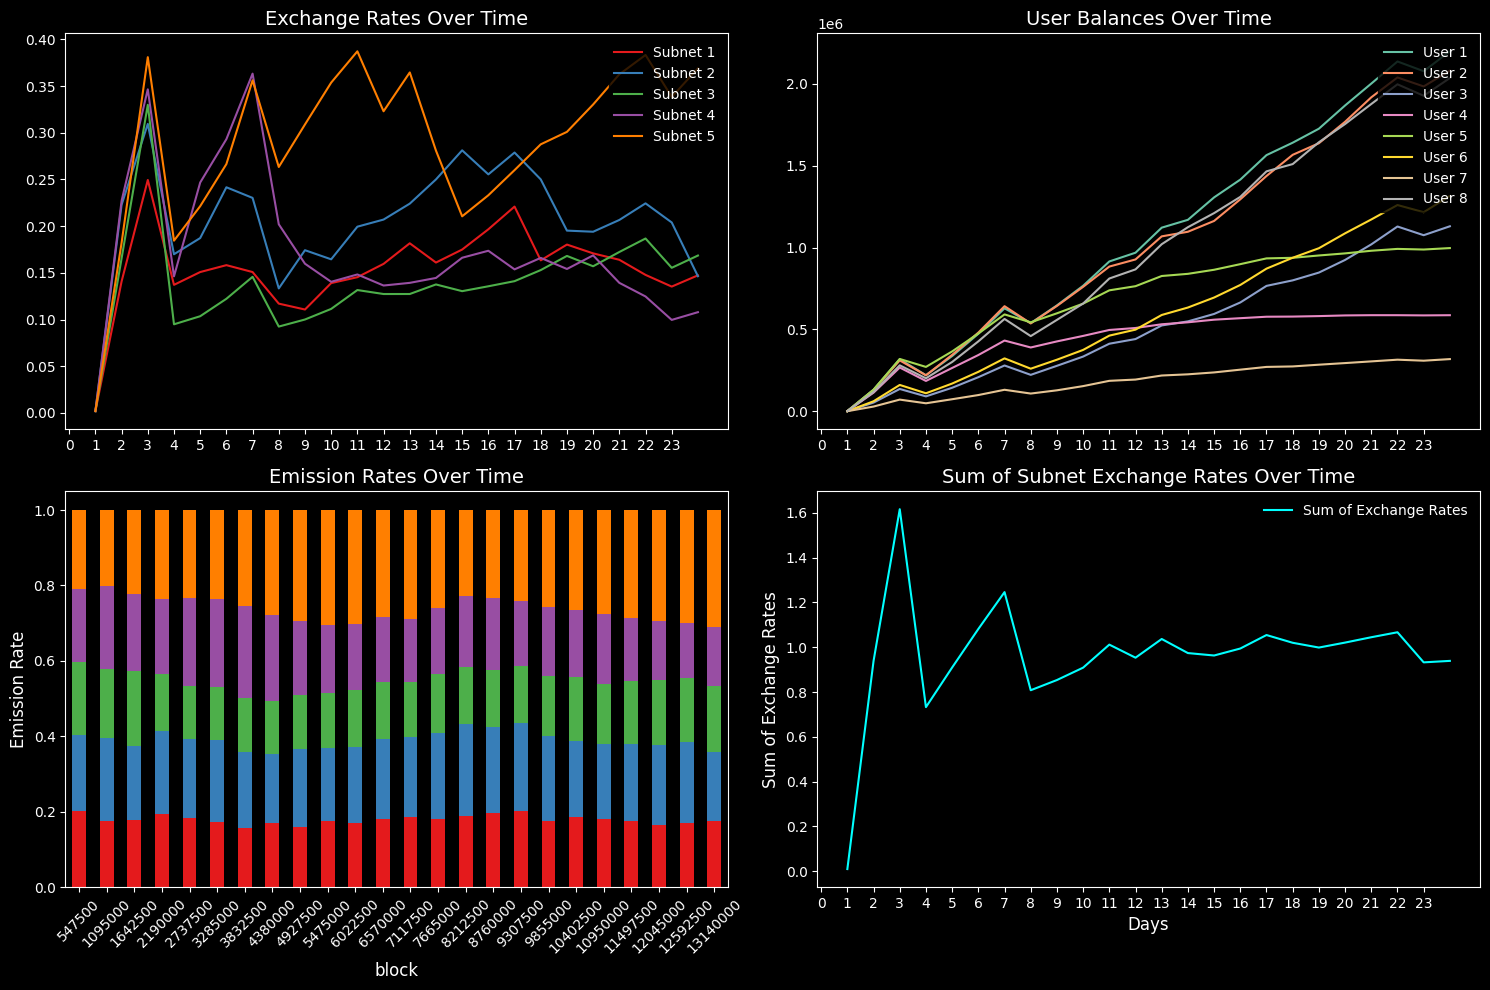

In [18]:
def setup_plot_style():
    plt.style.use('dark_background')
    fig = plt.figure(figsize=(15, 10))
    fig.patch.set_facecolor('black')
    return fig

def get_colors(df, id_column, cmap_name):
    num_items = df[id_column].nunique()
    return [plt.get_cmap(cmap_name)(i) for i in range(num_items)]

def setup_axis(ax, title, xlabel=None, ylabel=None):
    ax.set_facecolor('black')
    ax.set_title(title, color='white', fontsize=14)
    if xlabel: ax.set_xlabel(xlabel, color='white', fontsize=12)
    if ylabel: ax.set_ylabel(ylabel, color='white', fontsize=12)
    ax.tick_params(colors='white')
    return ax

def create_legend(ax, **kwargs):
    return ax.legend(loc='upper right', facecolor='black', edgecolor='black',
                    labelcolor='white', fontsize=10, **kwargs)

def plot_simulation_results(subnets_df, accounts_df, subtensor_df, blocks, n_steps):
    fig = setup_plot_style()

    checkpoints = np.linspace(0, blocks, (int(blocks/n_steps)) + 1, dtype=int)[:-1]
    day_labels = [str(i) for i in range(len(checkpoints))]
    non_root_subnets = [s for s in subnets_df['subnet_id'].unique() if s != 0]

    s_colors = get_colors(subnets_df[subnets_df['subnet_id'].isin(non_root_subnets)], 'subnet_id', 'Set1')
    a_colors = get_colors(accounts_df, 'account_id', 'Set2')

    ax1 = setup_axis(plt.subplot(2, 2, 1), 'Exchange Rates Over Time')
    for i, subnet in enumerate(non_root_subnets):
        subnet_data = subnets_df[subnets_df['subnet_id'] == subnet]
        ax1.plot(subnet_data['block'], subnet_data['exchange_rate'],
                label=f'Subnet {subnet}', color=s_colors[i])
    create_legend(ax1)

    ax2 = setup_axis(plt.subplot(2, 2, 2), 'User Balances Over Time')
    for i, account in enumerate(accounts_df['account_id'].unique()):
        account_data = accounts_df[accounts_df['account_id'] == account]
        ax2.plot(account_data['block'], account_data['market_value'],
                label=f'User {account}', color=a_colors[i])
    create_legend(ax2)

    ax3 = setup_axis(plt.subplot(2, 2, 3), 'Emission Rates Over Time',
                     'Blocks', 'Emission Rate')
    filtered_df = subnets_df[subnets_df['subnet_id'] != 0]
    emission_data = filtered_df.pivot(index='block', columns='subnet_id',
                                    values='emission_rate').fillna(0)
    emission_data.plot(kind='bar', stacked=True, ax=ax3, color=s_colors, legend=False)
    ax3.tick_params(axis='x', rotation=45)

    ax4 = setup_axis(plt.subplot(2, 2, 4), 'Sum of Subnet Exchange Rates Over Time',
                     'Days', 'Sum of Exchange Rates')
    ax4.plot(subtensor_df['block'], subtensor_df['sum_prices'],
             color='cyan', label='Sum of Exchange Rates')
    create_legend(ax4)

    for ax in [ax1, ax2, ax4]:
        ax.set_xticks(checkpoints)
        ax.set_xticklabels(day_labels)

    plt.tight_layout()
    plt.show()

plot_simulation_results(subnets_df, accounts_df, subtensor_df, blocks, n_steps)

    block  account_id  free_balance  market_value  \
0       1           1           0.0    101.497753   
1       2           1           0.0    104.484305   
2       3           1           0.0    107.458976   
3       4           1           0.0    110.421836   
4       5           1           0.0    113.372957   
5       6           1           0.0    116.312407   
6       7           1           0.0    119.240257   
7       8           1           0.0    122.156573   
8       9           1           0.0    125.061425   
9      10           1           0.0    127.954880   
10     11           1           0.0    130.837004   
11     12           1           0.0    133.707865   
12     13           1           0.0    136.567528   
13     14           1           0.0    139.416058   
14     15           1           0.0    142.253521   
15     16           1           0.0    145.079981   
16     17           1           0.0    147.895501   
17     18           1           0.0    150.700

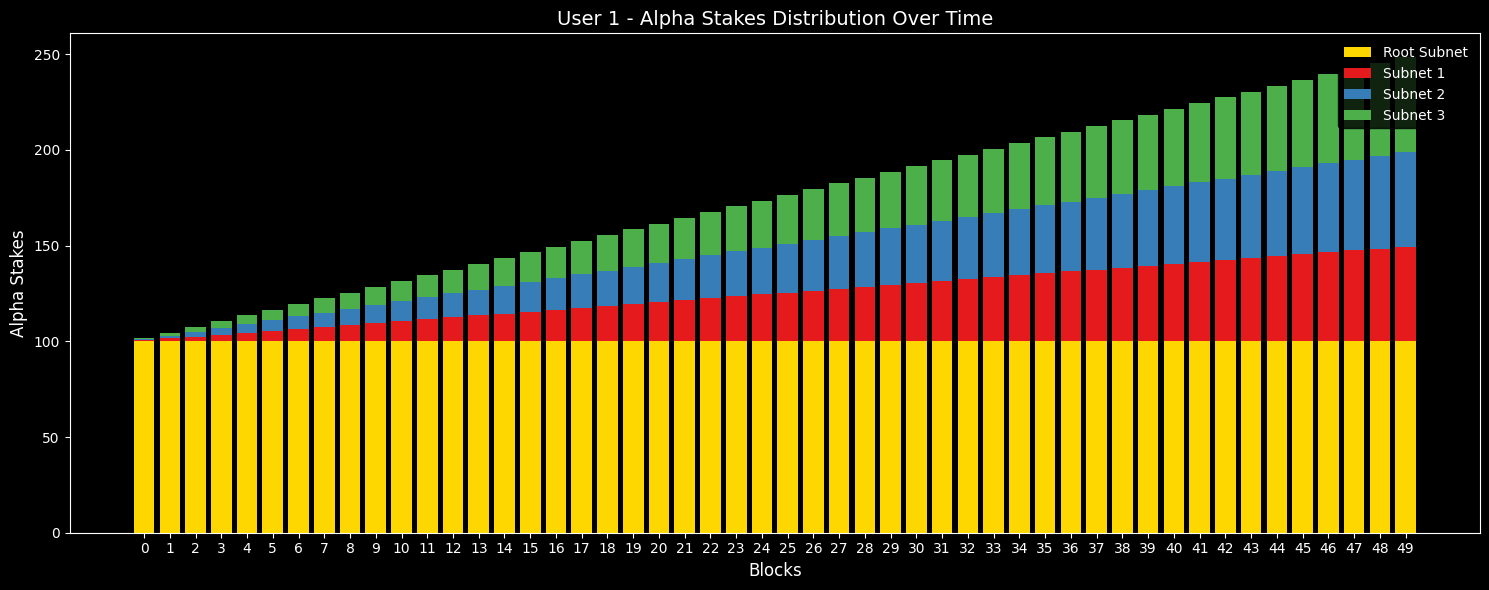

In [70]:
def plot_user_stakes_distribution(accounts_df, blocks, n_steps, user_id=1):
    plt.style.use('dark_background')
    fig = plt.figure(figsize=(15, 6))
    fig.patch.set_facecolor('black')

    print(accounts_df)
    subnet_ids = sorted([k for k in accounts_df['alpha_stakes'].iloc[0].keys()])
    print(subnet_ids)

    colors = []
    colors.append('gold')
    other_colors = [plt.get_cmap('Set1')(i) for i in range(len(subnet_ids)-1)]
    colors.extend(other_colors)

    ax = plt.gca()
    ax.set_facecolor('black')

    user_data = accounts_df[accounts_df['account_id'] == user_id]

    stakes_data = []
    for _, row in user_data.iterrows():
        stakes = []
        for subnet_id in subnet_ids:
            stakes.append(row['alpha_stakes'].get(subnet_id, 0.0))
        stakes_data.append(stakes)

    stakes_data = np.array(stakes_data)

    checkpoints = np.linspace(0, blocks, (int(blocks/n_steps)) + 1, dtype=int)[:-1]
    day_labels = [str(i) for i in range(len(checkpoints))]

    bottom = np.zeros(len(stakes_data))
    bars = []
    for i, subnet_id in enumerate(subnet_ids):
        label = 'Root Subnet' if subnet_id == 0 else f'Subnet {subnet_id}'
        bars.append(
            ax.bar(range(len(stakes_data)), stakes_data[:, i], bottom=bottom,
                  color=colors[i], label=label)
        )
        bottom += stakes_data[:, i]

    ax.set_title(f'User {user_id} - Alpha Stakes Distribution Over Time',
                color='white', fontsize=14)
    ax.set_xlabel('Blocks', color='white', fontsize=12)
    ax.set_ylabel('Alpha Stakes', color='white', fontsize=12)
    ax.tick_params(colors='white')

    ax.set_xticks(range(len(stakes_data)))
    ax.set_xticklabels(day_labels)

    ax.legend(loc='upper right', facecolor='black', edgecolor='black',
             labelcolor='white', fontsize=10)

    plt.tight_layout()
    plt.show()

plot_user_stakes_distribution(accounts_df, blocks, n_steps)


In [20]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print(trades_df[trades_df['account_id'] == 1])

        block  account_id  subnet_id action               amount
0           0           1          5    buy   42.623066619985295
1           0           1          3    buy    9.407745377885586
2           0           1          2    buy    19.45417207544626
41     643578           1          4    buy    6.031174917948669
55     965367           1          2    buy    4.870099322800491
70    1287156           1          1    buy    3.882776417723644
81    1608945           1          2   sell  31.851067812389033%
93    1930734           1          5    buy   3.0805669009422267
107   2252523           1          2   sell   49.79462163894491%
122   2574312           1          4    buy    5.134925547745808
136   2896101           1          1    buy    5.792842195102074
151   3217890           1          4   sell  27.543369823760532%
166   3539679           1          5    buy    4.897563736163394
181   3861468           1          4   sell   10.47354623618737%
197   4183257           1